# 加载之前权重看看

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary

# 设置随机种子保证可重复性
torch.manual_seed(42)

# 检查 GPU 可用性
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据准备与预处理
# 训练集数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集数据预处理
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载测试集
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# 定义类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# 获取当前运行文件所在的文件夹路径
import os
current_dir = os.getcwd()
# 设置 TORCH_HOME 环境变量为当前文件夹
os.environ['TORCH_HOME'] = current_dir

# 加载预训练模型
model = torchvision.models.resnet18(pretrained=True)

# 修改全连接层以适应 CIFAR - 10 数据集
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()  # 移除原模型中的 maxpool

model = model.to(device)

# 打印模型的结构信息
summary(model, (3, 32, 32))

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 模型权重文件路径
model_weights_path = r'E:\shuyang\代码文件\教学课件\面试班\25复试班\进阶项目\CNN\model_weights.pth'

# 加载之前保存的模型权重
try:
    model.load_state_dict(torch.load(model_weights_path))
    print(f'Model weights loaded from {model_weights_path}')
except FileNotFoundError:
    print(f'Weight file {model_weights_path} not found.')
    exit(1)

# 进入评估模式
model.eval()

val_running_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Inference on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

epoch_val_loss = val_running_loss / len(testloader)
epoch_val_accuracy = 100 * val_correct / val_total

# 打印推理结果
print(f'Test Loss: {epoch_val_loss:.4f}, Test Acc: {epoch_val_accuracy:.2f}%')

Using device: cuda:0
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 

Inference on test set: 100%|██████████| 100/100 [00:02<00:00, 35.71it/s]

Test Loss: 0.3098, Test Acc: 91.50%


## 尝试半监督策略

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      

Epoch 1/20: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]


Files already downloaded and verified
Epoch [1/20], Train Loss: 0.0046, Train Acc: 99.93%, Val Loss: 0.3461, Val Acc: 90.08%


Epoch 2/20: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


Files already downloaded and verified
Epoch [2/20], Train Loss: 0.0893, Train Acc: 97.02%, Val Loss: 0.3460, Val Acc: 90.28%


Epoch 3/20: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Files already downloaded and verified
Epoch [3/20], Train Loss: 0.0956, Train Acc: 96.73%, Val Loss: 0.4381, Val Acc: 87.76%


Epoch 4/20: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]


Files already downloaded and verified
Epoch [4/20], Train Loss: 0.0908, Train Acc: 96.99%, Val Loss: 0.3414, Val Acc: 91.00%


Epoch 5/20: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s]


Files already downloaded and verified
Epoch [5/20], Train Loss: 0.0897, Train Acc: 97.06%, Val Loss: 0.3223, Val Acc: 90.66%


Epoch 6/20: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Files already downloaded and verified
Epoch [6/20], Train Loss: 0.0840, Train Acc: 97.17%, Val Loss: 0.3354, Val Acc: 90.38%


Epoch 7/20: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]


Files already downloaded and verified
Epoch [7/20], Train Loss: 0.0839, Train Acc: 97.27%, Val Loss: 0.3209, Val Acc: 90.95%


Epoch 8/20: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s]


Files already downloaded and verified
Epoch [8/20], Train Loss: 0.0775, Train Acc: 97.38%, Val Loss: 0.3500, Val Acc: 90.52%


Epoch 9/20: 100%|██████████| 391/391 [00:22<00:00, 17.03it/s]


Files already downloaded and verified
Epoch [9/20], Train Loss: 0.0797, Train Acc: 97.33%, Val Loss: 0.3359, Val Acc: 90.64%


Epoch 10/20: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Files already downloaded and verified
Epoch [10/20], Train Loss: 0.0789, Train Acc: 97.35%, Val Loss: 0.3105, Val Acc: 91.20%


Epoch 11/20: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Files already downloaded and verified
Epoch [11/20], Train Loss: 0.0755, Train Acc: 97.49%, Val Loss: 0.3325, Val Acc: 91.08%


Epoch 12/20: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]


Files already downloaded and verified
Epoch [12/20], Train Loss: 0.0716, Train Acc: 97.61%, Val Loss: 0.3149, Val Acc: 91.39%


Epoch 13/20: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


Files already downloaded and verified
Epoch [13/20], Train Loss: 0.0724, Train Acc: 97.56%, Val Loss: 0.3071, Val Acc: 91.48%


Epoch 14/20: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]


Files already downloaded and verified
Epoch [14/20], Train Loss: 0.0700, Train Acc: 97.71%, Val Loss: 0.3313, Val Acc: 90.76%


Epoch 15/20: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Files already downloaded and verified
Epoch [15/20], Train Loss: 0.0756, Train Acc: 97.46%, Val Loss: 0.3638, Val Acc: 89.98%


Epoch 16/20: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


Files already downloaded and verified
Epoch [16/20], Train Loss: 0.0711, Train Acc: 97.63%, Val Loss: 0.3451, Val Acc: 90.65%


Epoch 17/20: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]


Files already downloaded and verified
Epoch [17/20], Train Loss: 0.0707, Train Acc: 97.62%, Val Loss: 0.3204, Val Acc: 91.16%


Epoch 18/20: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]


Files already downloaded and verified
Epoch [18/20], Train Loss: 0.0677, Train Acc: 97.75%, Val Loss: 0.3292, Val Acc: 91.27%


Epoch 19/20: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Files already downloaded and verified
Epoch [19/20], Train Loss: 0.0679, Train Acc: 97.73%, Val Loss: 0.3690, Val Acc: 90.09%


Epoch 20/20: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]


Files already downloaded and verified
Epoch [20/20], Train Loss: 0.0741, Train Acc: 97.60%, Val Loss: 0.3098, Val Acc: 91.50%
Model weights saved to E:\shuyang\代码文件\教学课件\面试班\25复试班\进阶项目\CNN\model_weights.pth


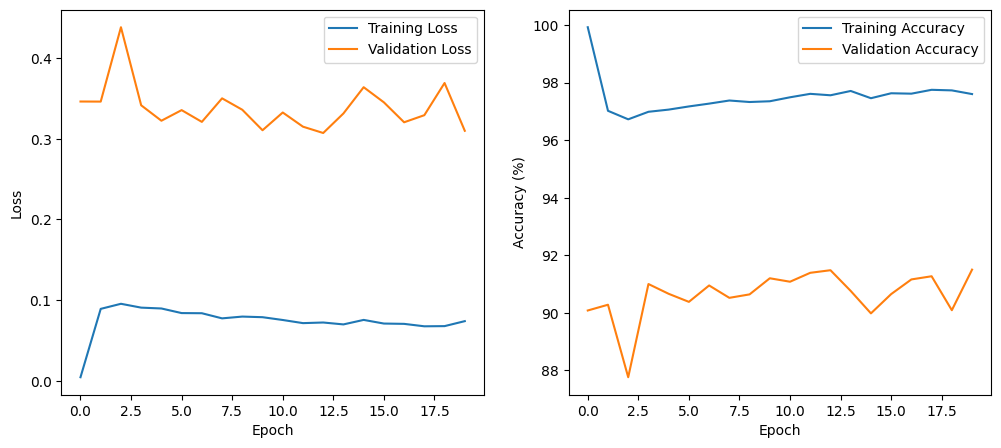

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary

# 设置随机种子保证可重复性
torch.manual_seed(42)

# 检查 GPU 可用性
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 数据准备与预处理
# 训练集数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集数据预处理
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载训练集
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

# 加载测试集
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# 定义类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# 获取当前运行文件所在的文件夹路径
import os
current_dir = os.getcwd()
# 设置 TORCH_HOME 环境变量为当前文件夹
os.environ['TORCH_HOME'] = current_dir

# 加载预训练模型
model = torchvision.models.resnet18(pretrained=True)

# 修改全连接层以适应 CIFAR - 10 数据集
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()  # 移除原模型中的 maxpool

model = model.to(device)

# 打印模型的结构信息
summary(model, (3, 32, 32))

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用 SGD 优化器，降低学习率
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 学习率调度器，使用余弦退火策略
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 模型权重文件路径
model_weights_path = r'E:\shuyang\代码文件\教学课件\面试班\25复试班\进阶项目\CNN\model_weights.pth'

# 加载之前保存的模型权重
try:
    model.load_state_dict(torch.load(model_weights_path))
    print(f'Model weights loaded from {model_weights_path}')
except FileNotFoundError:
    print(f'Weight file {model_weights_path} not found. Starting training from scratch.')

# 训练轮数
num_epochs = 20

# 用于存储每个 epoch 的损失值和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 伪标签阈值
pseudo_label_threshold = 0.9

# 训练循环
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()  # 设置模型为训练模式

    # 先使用标注数据进行训练
    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = images.to(device), labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 使用伪标签进行半监督训练
    unlabeled_trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    unlabeled_trainloader = torch.utils.data.DataLoader(
        unlabeled_trainset, batch_size=128, shuffle=True, num_workers=2)

    model.eval()
    confident_images_list = []
    confident_pseudo_labels_list = []
    with torch.no_grad():
        for images, _ in unlabeled_trainloader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, pseudo_labels = torch.max(probabilities, dim=1)
            confident_indices = max_probs > pseudo_label_threshold

            if confident_indices.sum() > 0:
                confident_images = images[confident_indices]
                confident_pseudo_labels = pseudo_labels[confident_indices]
                confident_images_list.append(confident_images)
                confident_pseudo_labels_list.append(confident_pseudo_labels)

    if confident_images_list:
        model.train()  # 确保模型处于训练模式
        for confident_images, confident_pseudo_labels in zip(confident_images_list, confident_pseudo_labels_list):
            optimizer.zero_grad()
            pseudo_outputs = model(confident_images)
            pseudo_loss = criterion(pseudo_outputs, confident_pseudo_labels)
            pseudo_loss.backward()
            optimizer.step()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # 验证阶段
    model.eval()  # 设置模型为评估模式
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(testloader)
    epoch_val_accuracy = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # 根据调度器更新学习率
    scheduler.step()

    # 打印训练信息
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')


# 可视化训练过程
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

可以看到半监督放进去 效果反而不好，这是因为原来的数据已经满足要求了，新的数据质量不高，并没有挖掘到新的信息，甚至可能降低准确度，但是这仍然是我们探索的过程。